In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
s_train = pd.read_csv('datasets/clean_train.csv')
s_test = pd.read_csv('datasets/clean_test.csv')

#### You can find the cleaned data sets in the Clean Data notebook below ####

In [3]:
# Clean notebook lives in (Clean_Data) in the same directory as this notebook. 

In [4]:
s_train.head()

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,0.0,13517,Pave,0,2,...,0,0,0,0,0,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,0,2,...,0,0,0,0,0,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,0,1,...,0,0,0,0,0,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,0,1,...,0,0,0,0,0,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,0,2,...,0,0,0,0,0,0,3,2010,WD,138500


In [5]:
s_test.head()

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,1,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,1,2718,905108090,90,RL,0.0,9662,Pave,NaN,2,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2,2414,528218130,60,RL,58.0,17104,Pave,NaN,2,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,3,1989,902207150,30,RM,60.0,8520,Pave,NaN,1,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,4,625,535105100,20,RL,0.0,9500,Pave,NaN,2,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


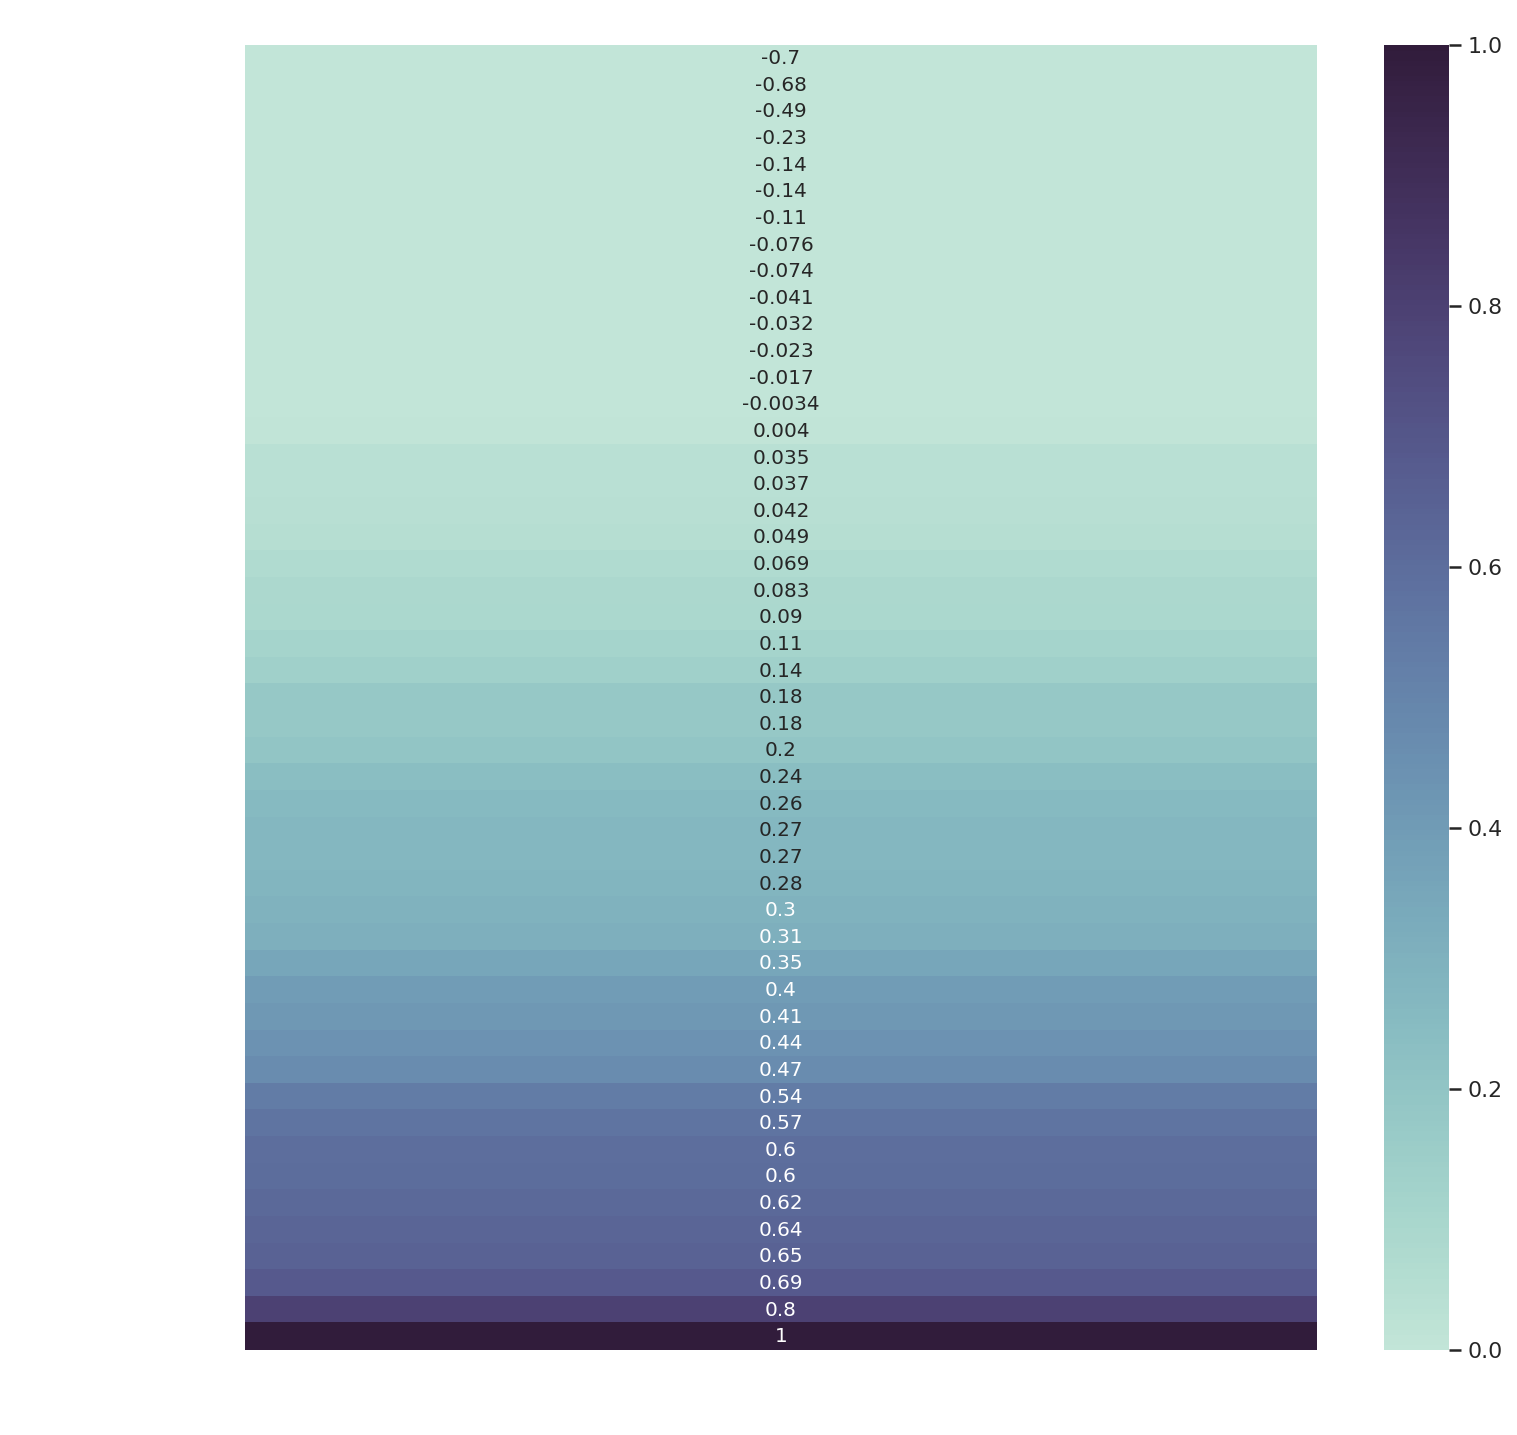

In [102]:
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
plt.figure(figsize = (12,12))
sns.heatmap(s_train.corr()[['saleprice']].sort_values('saleprice'), vmin=0, vmax=1, annot=True,cmap = cmap)
plt.title('Correlation Heatmap', color='white')
plt.xlabel('Sale Price', color='white')
plt.ylabel('Features', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.savefig('datasets/correlation_heatmap_graph', transparent=True);

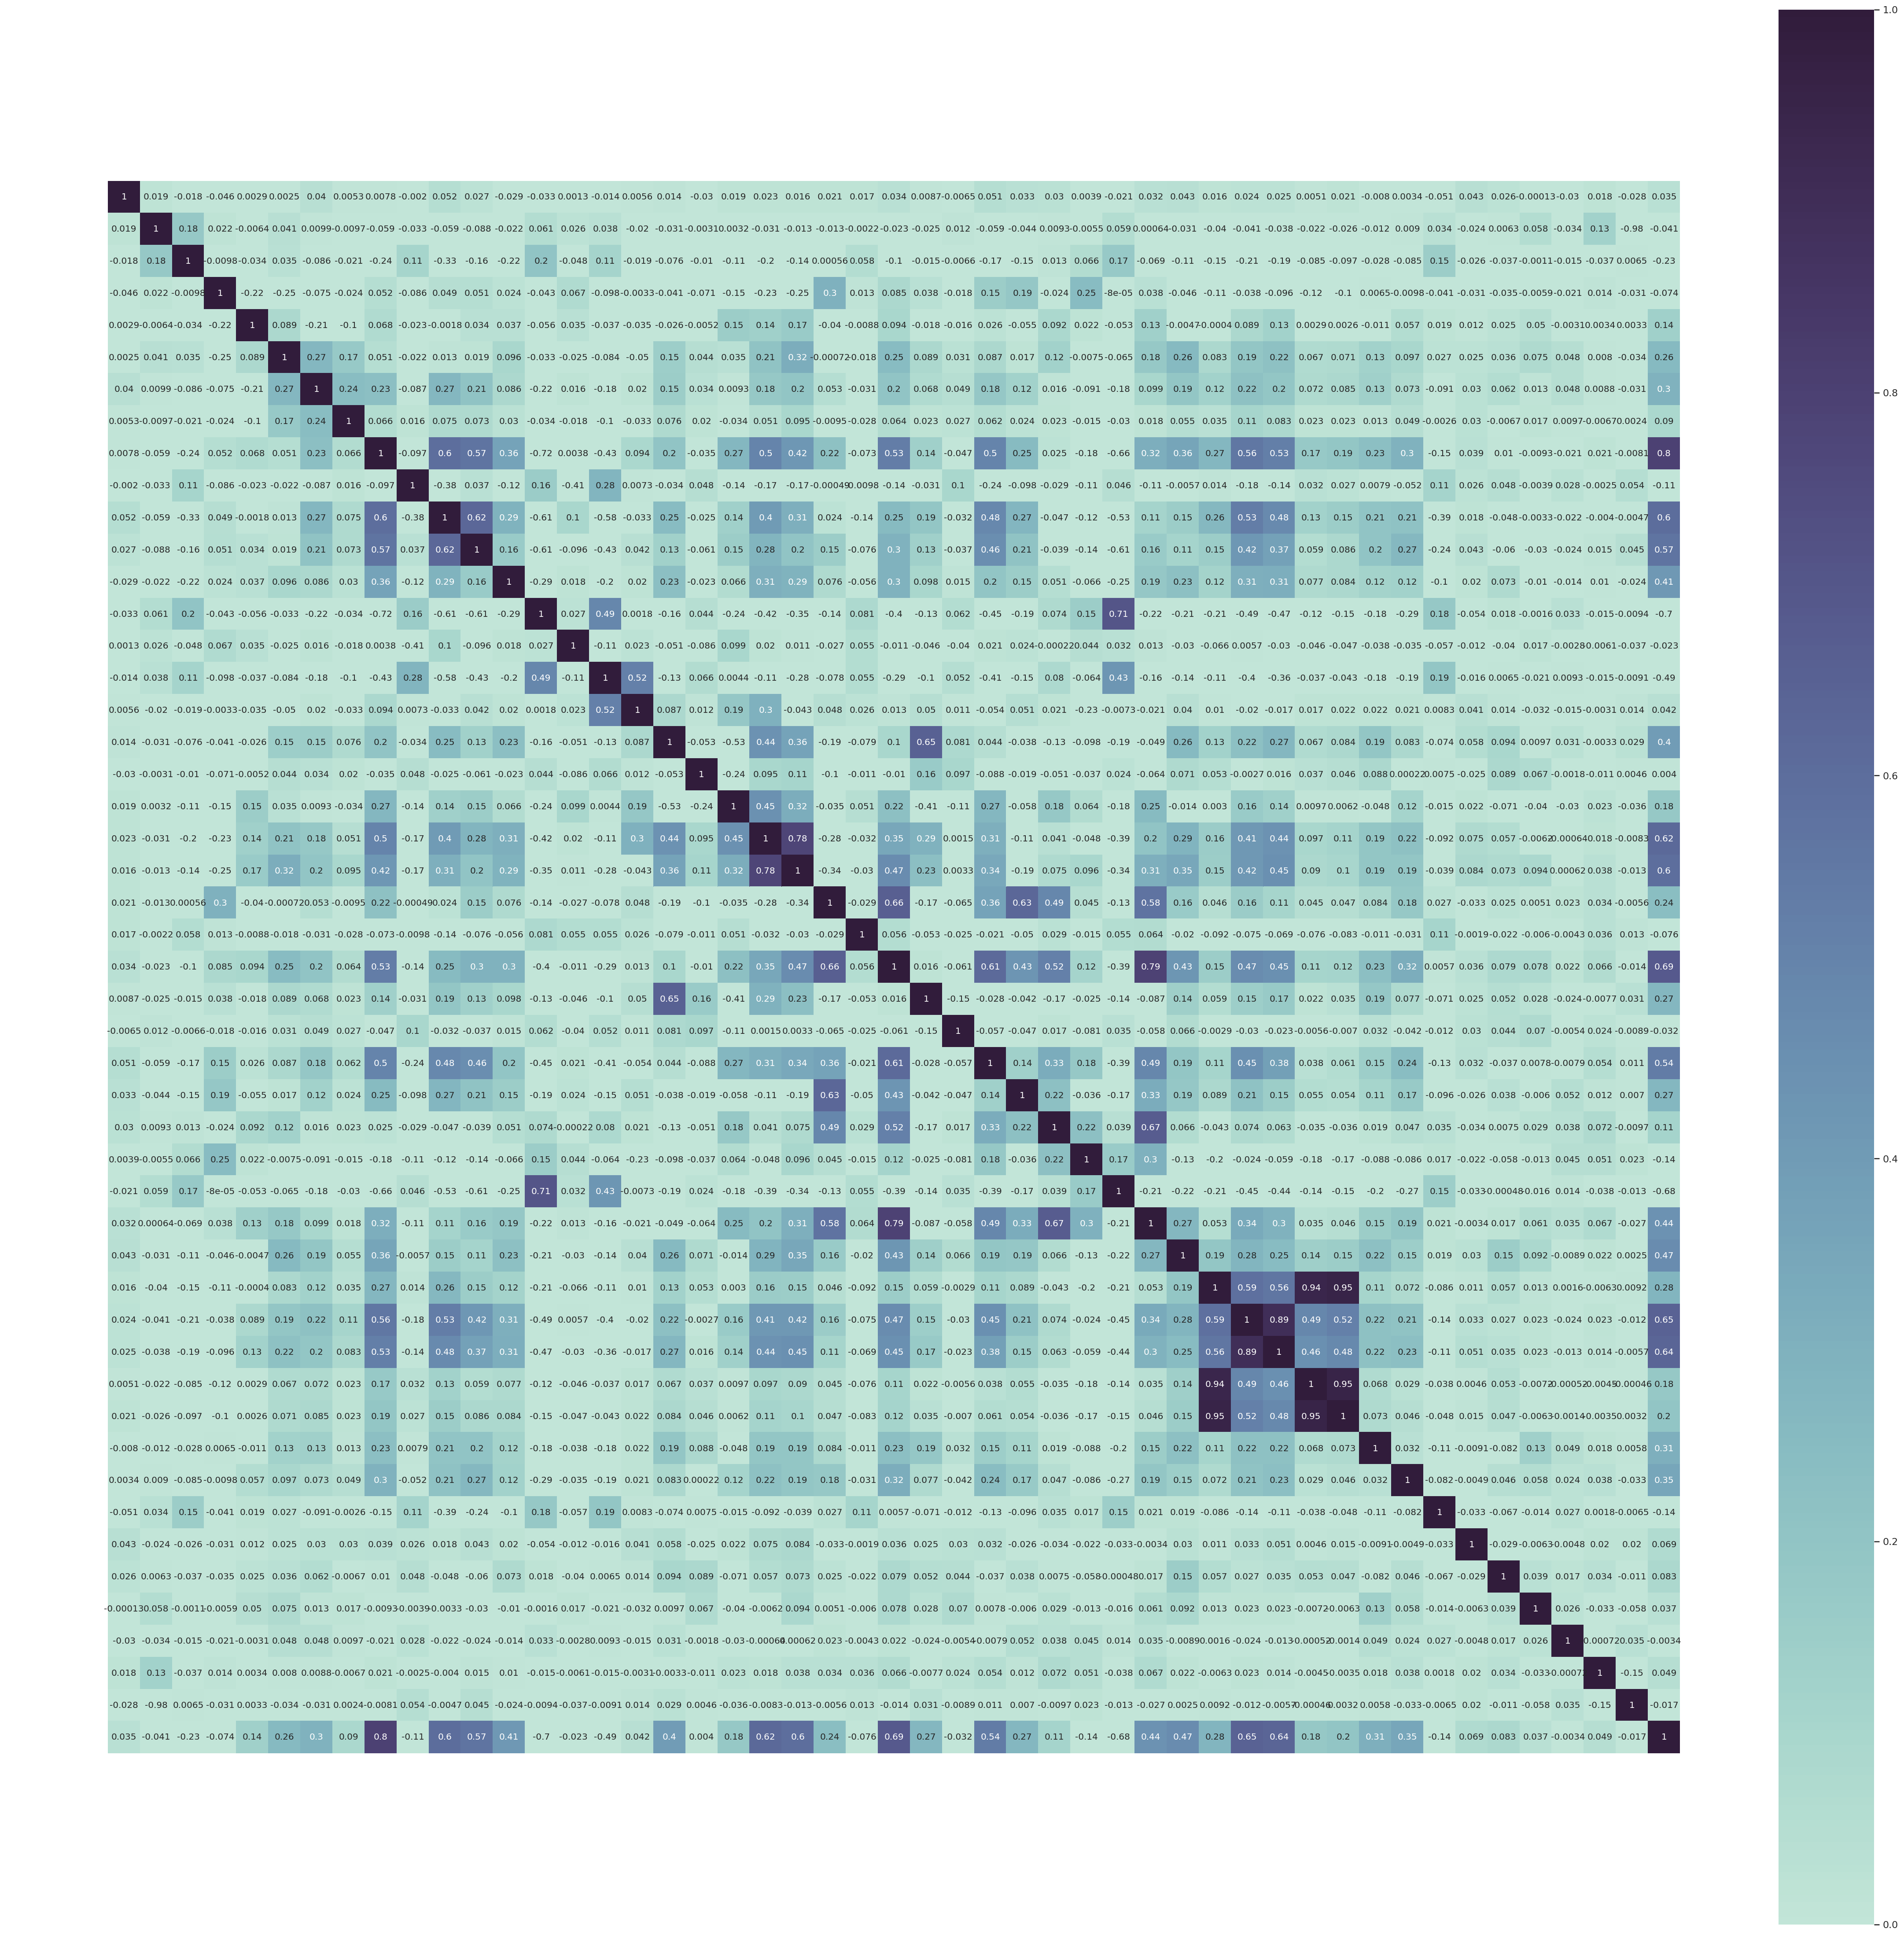

In [103]:
# Let's do a heatmap to see if we can see correlations otherwise!
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

corr = s_train.corr()
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corr, vmin=0, vmax=1, annot=True, square=True, cmap=cmap)
plt.title('Mega Heatmap', color='white')
plt.xlabel('Features', color='white')
plt.ylabel('Features', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.savefig('datasets/meaga_heatmap_graph', transparent=True);

In [8]:
#Trying out a small-ish model first. 
features = ['id', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'kitchen_qual', 'garage_qual', 'garage_cond']
X = s_train[features]
y = s_train['saleprice']
X_test_data = s_test[features]
print(X.describe())
print(y.describe())

                id   exter_qual   exter_cond    bsmt_qual    bsmt_cond  \
count  1986.000000  1986.000000  1986.000000  1986.000000  1986.000000   
mean   1478.004532     2.616818     2.910373     2.376636     2.913394   
std     844.782566     0.557702     0.367472     0.771754     0.560273   
min       1.000000     1.000000     1.000000     0.000000     0.000000   
25%     762.250000     2.000000     3.000000     2.000000     3.000000   
50%    1483.500000     3.000000     3.000000     2.000000     3.000000   
75%    2201.750000     3.000000     3.000000     3.000000     3.000000   
max    2930.000000     4.000000     5.000000     5.000000     5.000000   

       kitchen_qual  garage_qual  garage_cond  
count   1986.000000  1986.000000  1986.000000  
mean       2.510574     2.868580     2.856999  
std        0.637327     0.726851     0.717324  
min        1.000000     0.000000     0.000000  
25%        2.000000     3.000000     3.000000  
50%        3.000000     3.000000     3.000000

In [9]:
# Set up train test split with training data at 80%, test data 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=76)

In [10]:
# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [11]:
# Just checking shape to make sure it's what we expect
X_scaled.shape

(1588, 8)

In [12]:
# check type
type(X_scaled)

numpy.ndarray

In [13]:
# Checking shape on teset data to make sure it's what we expect
X_test_scaled.shape

(398, 8)

In [14]:
# Look at correlated data using our chosen features
X_train.corr(),s_train['saleprice'].sort_values()

(                    id  exter_qual  exter_cond  bsmt_qual  bsmt_cond  \
 id            1.000000    0.049658    0.009648   0.034438  -0.023362   
 exter_qual    0.049658    1.000000    0.027028   0.488486   0.008770   
 exter_cond    0.009648    0.027028    1.000000  -0.081762   0.040320   
 bsmt_qual     0.034438    0.488486   -0.081762   1.000000   0.520444   
 bsmt_cond    -0.023362    0.008770    0.040320   0.520444   1.000000   
 kitchen_qual  0.043562    0.695504    0.036526   0.419707  -0.006696   
 garage_qual   0.003646   -0.125158   -0.041386  -0.064325   0.002244   
 garage_cond   0.003446   -0.142984   -0.042261  -0.066256   0.008003   
 
               kitchen_qual  garage_qual  garage_cond  
 id                0.043562     0.003646     0.003446  
 exter_qual        0.695504    -0.125158    -0.142984  
 exter_cond        0.036526    -0.041386    -0.042261  
 bsmt_qual         0.419707    -0.064325    -0.066256  
 bsmt_cond        -0.006696     0.002244     0.008003  
 kitc

### Linear Regression Modeling ###

In [15]:
# Set up Linear Regression model
lr = LinearRegression()

In [16]:
# fit the data
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
# Let's check those scores
lr_scores = cross_val_score(lr, X_scaled, y_train, cv=3)
lr_scores.mean()
# Not great...

0.6028967530715204

### Lasso Score Modeling ###

In [18]:
# Set our lasso model
lasso = LassoCV(n_alphas=30)

In [19]:
# Fit teh data to the model
lasso.fit(X_scaled, y_train)

LassoCV(n_alphas=30)

In [20]:
# Now for the lasso scores utilizing cross_val_score
lasso_scores = cross_val_score(lasso, X_test_scaled, y_test, cv=3)
lasso_scores.mean()
# Looks worse than the linear regression scores. 

0.5657649512165851

### Testing with Ridge Model ###

In [21]:
# Setting up the ridge model
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100), cv=5)

In [22]:
# Fit that model
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=5)

In [23]:
ridge.intercept_

342408.64734586864

In [24]:
# Look at the ridge scores!
ridge_score = ridge.score(X_train, y_train)
ridge_score
# They're looking slightly better than the training scores

0.6086181674543092

In [25]:
# Ridge score for test data (from train test split on training data)
ridge.score(X_test, y_test)

0.596272936654837

In [26]:
# Make some predictions
pred = ridge.predict(X_test)
pred[:10]

array([156484.90187868, 227976.72949888, 232263.7335693 , 157785.32074191,
       157261.77548528, 132857.51755961, 158983.35273036, 159195.51522346,
       227272.68779289, 252482.31876455])

In [27]:
# Calculate Residuals
residuals = y_test - pred
residuals

1838     17515.098121
179     -51976.729499
122     -82263.733569
1179    -33785.320742
1140     28638.224515
            ...      
1842      4607.304732
719      -2750.130250
17        7305.681781
263     118279.777355
274      49972.628332
Name: saleprice, Length: 398, dtype: float64

In [28]:
# Check R2 score for fun
r2_score(y_test, pred)

0.596272936654837

## Data Visualization ##

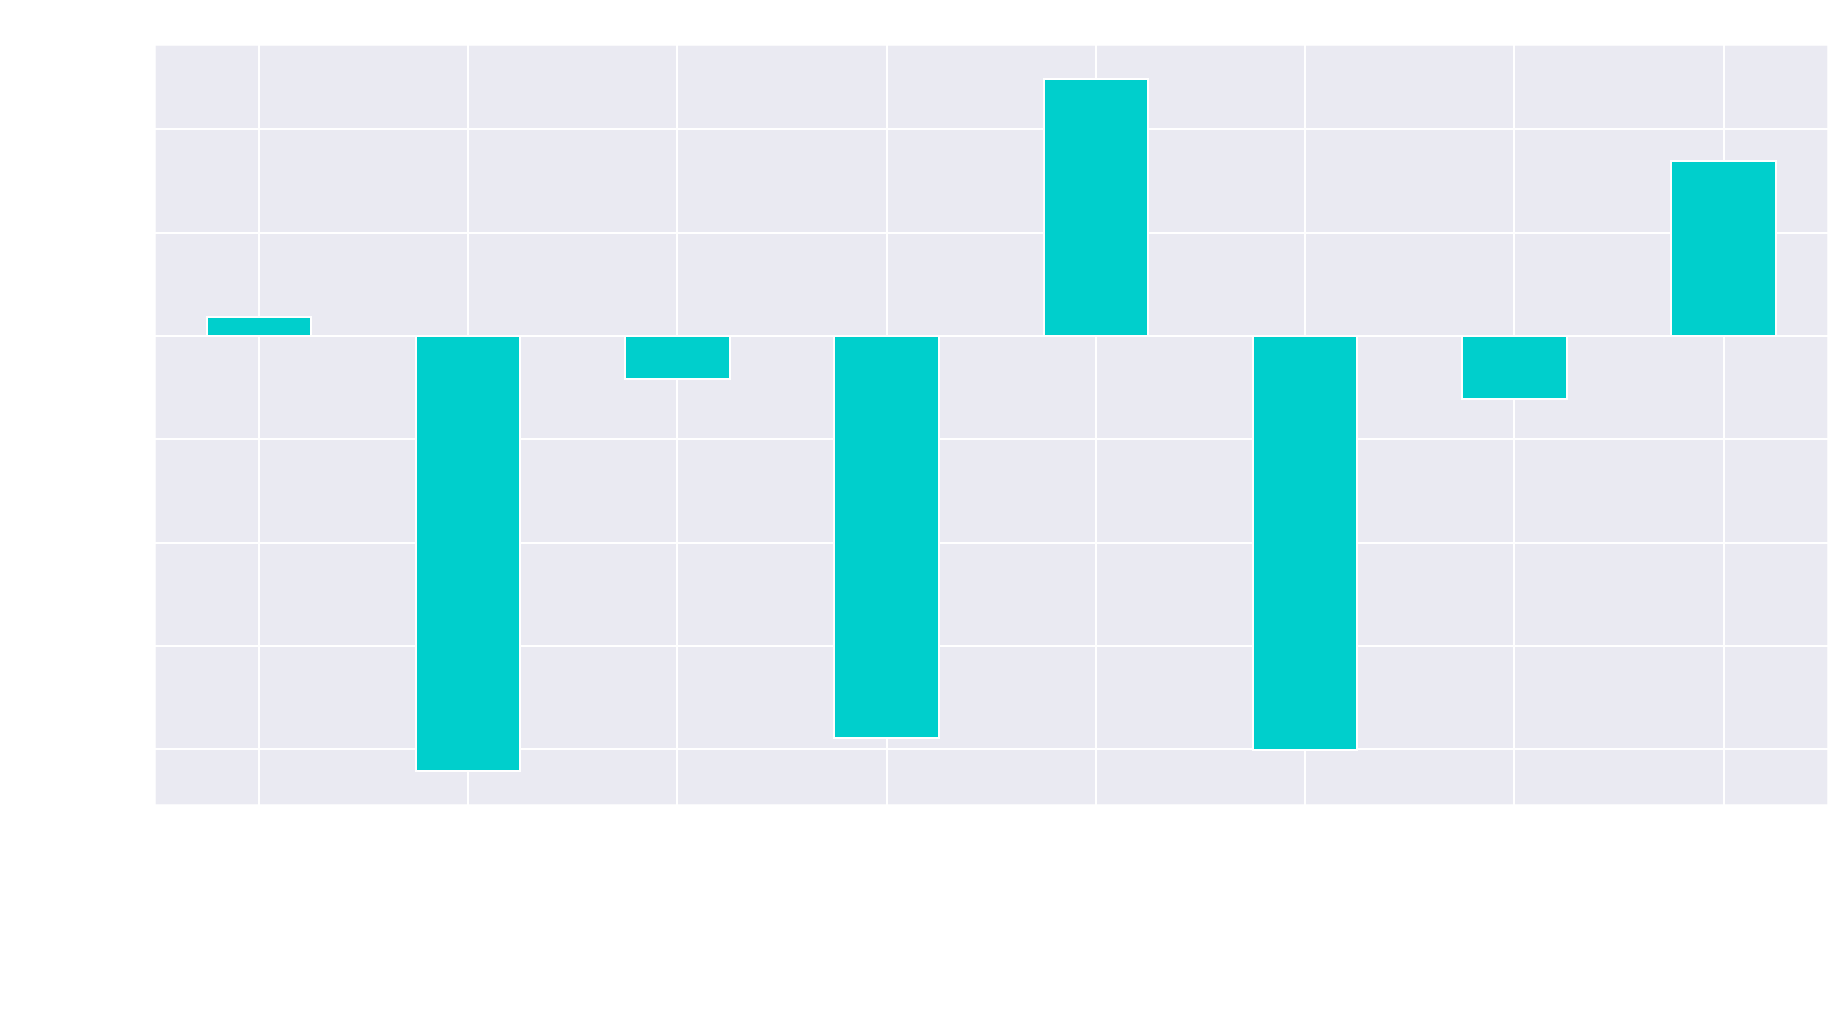

In [98]:
# Let's take a look at the coefficients of each feature 
pd.Series(ridge.coef_, index=features).plot.bar(figsize=(15, 7), color='#00cfcc')
plt.title('Features against Ridge Coefficient', color='white')
plt.xlabel('Features', color='white')
plt.ylabel('Coefficient Value', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.savefig('datasets/feature_coefficients_graph', transparent=True);
# Text is white for presentation

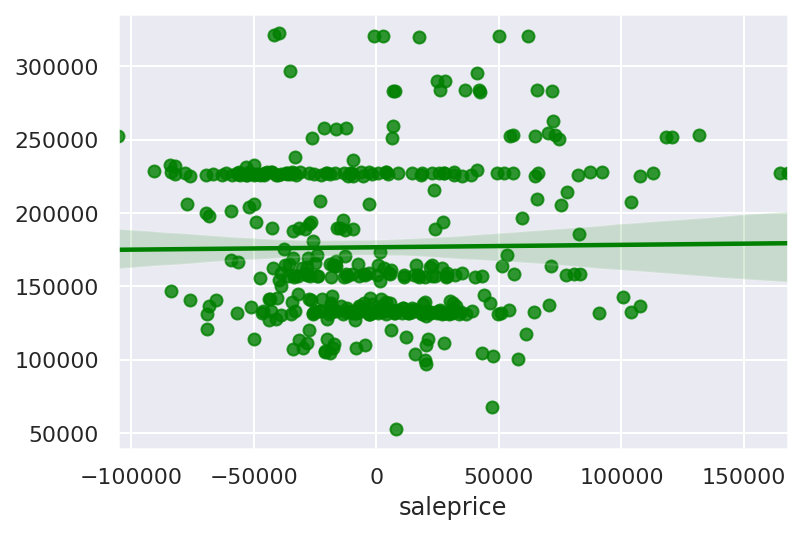

In [30]:
# Scatter plot of our predctions and y_test data
sns.regplot(x=residuals, y=pred, color='green');
# plt.scatter(pred, y_test, color='green')

In [31]:
# I found this cool way to do a ridge coefficients data frame here: 
ridge_df = pd.DataFrame([ridge.coef_, features], index = ['Coefficients', 'Features']).T
ridge_df = ridge_df.set_index('Features')
ridge_df['Coefficients'] = np.abs(ridge_df['Coefficients'])
ridge_df = ridge_df.sort_values(by='Coefficients',ascending=False)
ridge_df.head(10)

,Coefficients
Features,
exter_qual,37781.6
kitchen_qual,31486.3
bsmt_qual,25221.2
bsmt_cond,22049.1
garage_cond,11851.2
exter_cond,5644.42
garage_qual,4275.88
id,1.05553


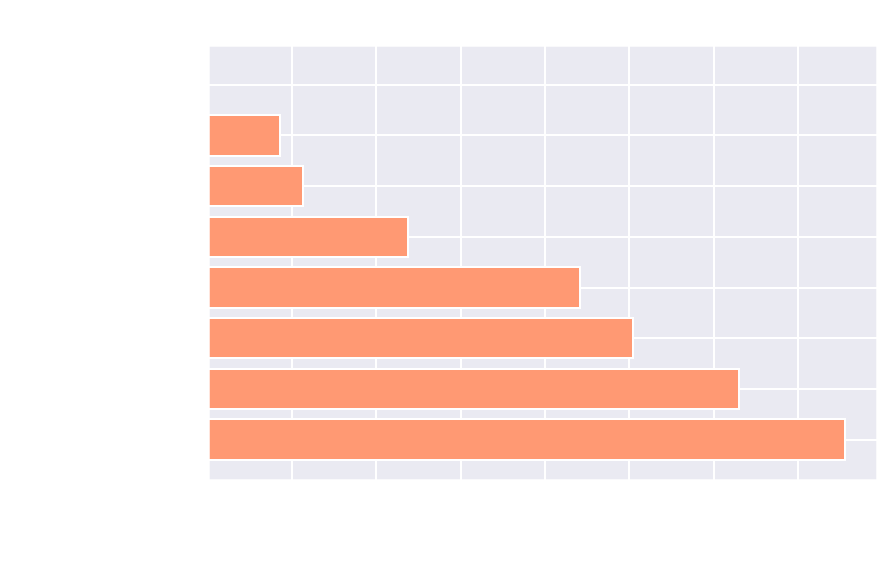

In [96]:
# More visualization of what features have the most impact on sale price
plt.barh(y=ridge_df.index[:10], width=ridge_df['Coefficients'][0:10], color='#ff9973')
plt.title('Impact on Sale Price', color='white')
plt.xlabel('Strenth of Predictor', color='white')
plt.ylabel('Features', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.savefig('datasets/confidence_graph', transparent=True);

Text(0.5, 1.0, 'Distribution of Residuals')

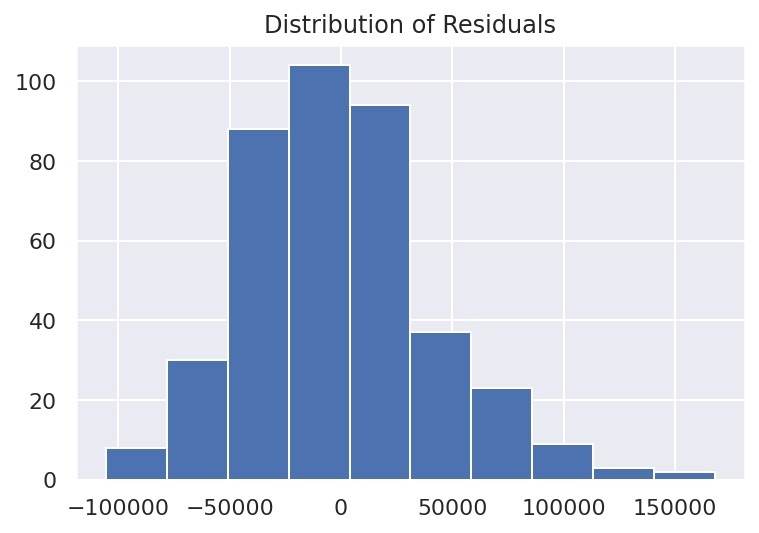

In [33]:
# Histogram of residauals
plt.hist(residuals);
plt.title('Distribution of Residuals')

Text(0.5, 1.0, 'Transformed Residuals')

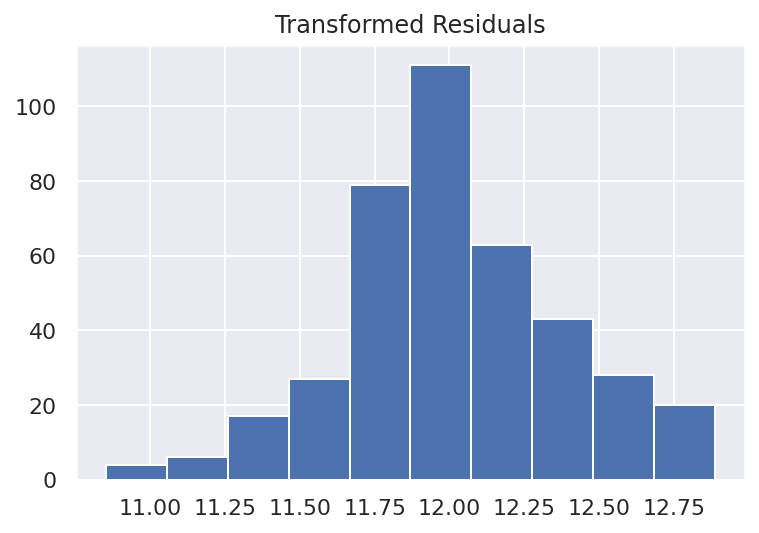

In [34]:
# Plot histogram of log(y_test)
plt.hist(np.log(y_test));
plt.title('Transformed Residuals')

Text(0.5, 1.0, 'Comparing Predicted Prices with Residuals')

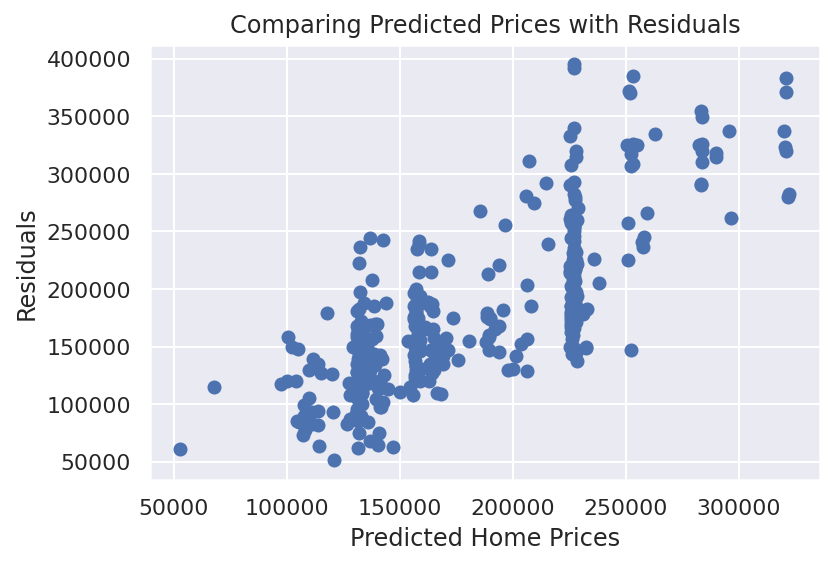

In [35]:

plt.scatter(x=pred,y=y_test)
plt.xlabel('Predicted Home Prices')
plt.ylabel('Residuals')
plt.title('Comparing Predicted Prices with Residuals')

# Now with Test data #

In [36]:
# Checking data shapes
s_test.shape

(878, 81)

In [37]:
# Checking test data head
X_test_data.head()

,id,exter_qual,exter_cond,bsmt_qual,bsmt_cond,kitchen_qual,garage_qual,garage_cond
0,2658,3,4,4,3,4,5,5
1,2718,3,3,2,3,3,3,3
2,2414,2,3,2,2,2,3,3
3,1989,2,3,3,3,3,4,3
4,625,3,3,2,3,3,3,3


In [38]:
# test features correlation with train data sale price
X_test_data.corr(),s_train['saleprice'].sort_values()

(                    id  exter_qual  exter_cond  bsmt_qual  bsmt_cond  \
 id            1.000000    0.018423   -0.011977   0.005535  -0.024879   
 exter_qual    0.018423    1.000000    0.016176   0.474682  -0.050067   
 exter_cond   -0.011977    0.016176    1.000000  -0.073146   0.059852   
 bsmt_qual     0.005535    0.474682   -0.073146   1.000000   0.515397   
 bsmt_cond    -0.024879   -0.050067    0.059852   0.515397   1.000000   
 kitchen_qual  0.022374    0.677035    0.039211   0.414835  -0.066872   
 garage_qual   0.034550   -0.113893   -0.029289   0.035840   0.067778   
 garage_cond   0.021028   -0.128664    0.006398   0.012266   0.069084   
 
               kitchen_qual  garage_qual  garage_cond  
 id                0.022374     0.034550     0.021028  
 exter_qual        0.677035    -0.113893    -0.128664  
 exter_cond        0.039211    -0.029289     0.006398  
 bsmt_qual         0.414835     0.035840     0.012266  
 bsmt_cond        -0.066872     0.067778     0.069084  
 kitc

In [39]:
# predicting test data with ridge scoring model
test_pred = ridge.predict(X_test_data)

In [40]:
# look at the prediction first 10
test_pred[:10]

array([ 86485.85381206, 158971.74184765, 205869.52898629, 166486.69123509,
       156762.50752886, 131233.04951536, 132282.2510982 , 166445.55761655,
       225470.88990366, 132536.63498297])

In [41]:
# set up data for a for a y variable
s_test['saleprice'] = test_pred

In [42]:
# check our data
s_test.head()

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,1,...,0,0,NaN,NaN,NaN,0,4,2006,WD,86485.853812
1,1,2718,905108090,90,RL,0.0,9662,Pave,NaN,2,...,0,0,NaN,NaN,NaN,0,8,2006,WD,158971.741848
2,2,2414,528218130,60,RL,58.0,17104,Pave,NaN,2,...,0,0,NaN,NaN,NaN,0,9,2006,New,205869.528986
3,3,1989,902207150,30,RM,60.0,8520,Pave,NaN,1,...,0,0,NaN,NaN,NaN,0,7,2007,WD,166486.691235
4,4,625,535105100,20,RL,0.0,9500,Pave,NaN,2,...,185,0,NaN,NaN,NaN,0,7,2009,WD,156762.507529


In [43]:
# use test_pred for y_test_data
y_test_data = test_pred

In [44]:
# Scale test set
X_td_scaled = sc.transform(X_test_data)
# y_td_scaled = sc.transform(y_test_data)

In [45]:
# check scaled shape
X_td_scaled.shape

(878, 8)

In [46]:
# Fit our ridge model with test data
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100)).fit(X_td_scaled, y_test_data)
ridge

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]))

In [47]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=3)
ridge_scores.mean()

0.6034292987834449

In [48]:
# ridge score with test data
ridge.score(X_td_scaled, y_test_data)

0.9999999899534785

In [49]:
# Check our test columns before creating export data
s_test.columns

Index(['Unnamed: 0', 'id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage',
       'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_b

In [50]:
# Reintroduce properly capitalized column names for ID and SalePrice
s_test.rename(columns={'id': 'ID', 'saleprice': 'SalePrice'}, errors="raise", inplace=True)

In [51]:
# set submission to just the columns we want
submission = s_test[['ID', 'SalePrice']]

In [52]:
# Export to csv
submission.to_csv('datasets/submission_1.csv', index=False)

# Trying out Grid Search #

In [53]:
# Instantiate.
knn = KNeighborsClassifier(n_neighbors=50)

# Fit.
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [54]:
# Evaluate.
knn.score(X_test, y_test)

0.007537688442211055

In [55]:
# Evaluate against the baseline.
y_test.value_counts(normalize=True)

130000    0.020101
135000    0.017588
170000    0.015075
147000    0.015075
145000    0.012563
            ...   
256000    0.002513
121000    0.002513
245500    0.002513
395000    0.002513
179200    0.002513
Name: saleprice, Length: 267, dtype: float64

In [56]:
# Set a random seed.
np.random.seed(42)

# Let's try 2-NN, 3-NN.
neighbors_to_test = [2, 3]

# Let's try uniform and distance weightings.
weightings_to_test = ['uniform', 'distance']

# Let's try Manhattan and Euclidean distances.
distance_metrics_to_test = [1, 2] # Remember that p = 1 is Manhattan, p = 2 is Euclidean

# Instantiate a dictionary to hold our accuracy scores.
accuracies = {}

# Loop through number of neighbors.
for k in neighbors_to_test:
    
    # Loop through the weightings.
    for w in weightings_to_test:
        
        # Loop through our distance metrics.
        for d in distance_metrics_to_test:
            
            # Instantiate a kNN model with that set of hyperparameters.
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, p=d)
            
            # Generate a set of accuracy scores based on 5-fold cross-validation.
            cv_accuracies = cross_val_score(knn, X_train, y_train, cv=5)
            
            # Average the five accuracy scores and store them in the dictionary.
            accuracies[(k, w, d)] = np.mean(cv_accuracies)

/home/khelm/.local/share/virtualenvs/workspace-ksSBG8c9/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/khelm/.local/share/virtualenvs/workspace-ksSBG8c9/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/khelm/.local/share/virtualenvs/workspace-ksSBG8c9/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/khelm/.local/share/virtualenvs/workspace-ksSBG8c9/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated clas

In [57]:
# Create dictionary of hyperparameters.
# The keys MUST match the names of the arguments!
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}

In [58]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # What is the model we want to fit?
                              knn_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)

In [59]:
# Fit the GridSearchCV object to the data
knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/khelm/.local/share/virtualenvs/workspace-ksSBG8c9/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished


In [60]:
# Print out the score
# from documentation: Mean cross-validated score of the best_estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

knn_gridsearch.best_score_

0.012598456441084857

In [61]:
# Print out the set of hyperparameters that achieved the best score.
knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 41}

In [62]:
# Evaluate the best fit model on the test data.
knn_gridsearch.score(X_test, y_test)

0.005025125628140704

In [63]:
pd.DataFrame(knn_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.005350,0.001192,0.028003,0.000696,manhattan,41,"{'metric': 'manhattan', 'n_neighbors': 41}",0.009434,0.009434,0.012579,0.018927,0.012618,0.012598,0.003467,1
4,0.004630,0.000032,0.026598,0.000197,euclidean,41,"{'metric': 'euclidean', 'n_neighbors': 41}",0.009434,0.006289,0.009434,0.018927,0.012618,0.011341,0.004289,2
8,0.004670,0.000072,0.026540,0.000071,manhattan,31,"{'metric': 'manhattan', 'n_neighbors': 31}",0.006289,0.012579,0.009434,0.012618,0.012618,0.010708,0.002528,3
3,0.004583,0.000032,0.025915,0.000115,euclidean,31,"{'metric': 'euclidean', 'n_neighbors': 31}",0.006289,0.009434,0.009434,0.012618,0.012618,0.010079,0.002370,4
0,0.004671,0.000175,0.022673,0.000203,euclidean,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.009434,0.012579,0.009434,0.003155,0.009464,0.008813,0.003079,5


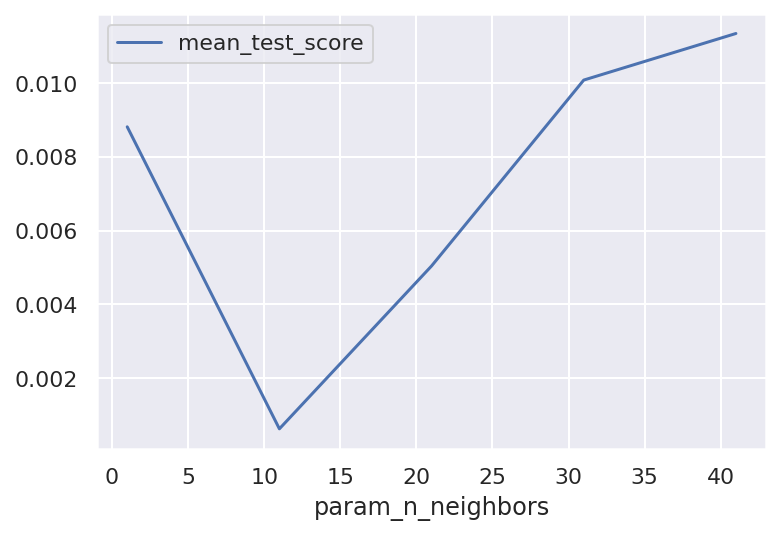

In [64]:
gs_df = pd.DataFrame(knn_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_metric'] == 'euclidean']
gs_df.plot(x='param_n_neighbors', y='mean_test_score');